In [53]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [54]:
dfmacd = pd.read_csv("ibmmacd.csv")
df = pd.read_csv("ibm.csv")
dfmfi = pd.read_csv("ibmmfi.csv")
startdate = dfmfi['time'][0]
enddate = "2000-01-01"
# print(startdate)
# print(df)
df = df.loc[(df["timestamp"] >= enddate ) & (df["timestamp"] <= startdate)]
dfmacd = dfmacd.loc[(dfmacd["time"] >= enddate ) & (dfmacd["time"] <= startdate)]
dfmfi = dfmfi.loc[(dfmfi["time"] >= enddate ) & (dfmfi["time"] <= startdate)]
dffinal = pd.concat([df[['open','high','low','volume']], dfmacd['MACD'], dfmfi["MFI"],df['adjusted_close']],axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
df_min_max_scaled = sc.fit_transform(dffinal)
res_scaled = sc.fit_transform(pd.DataFrame(df['adjusted_close']))

# for column in df_min_max_scaled.columns:
#     df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
# df_min_max_scaled
# pd.DataFrame(df['adjusted_close'])


In [55]:
x_train, x_test, y_train, y_test = train_test_split(df_min_max_scaled,res_scaled,test_size=0.2,shuffle=False)
# df_min_max_scaled
# x_train.shape
a = []
b = []
for _ in range(100,x_train.shape[0]):
    a.append(x_train[_-100:_])
    b.append(y_train[_,0])
x_train, y_train = np.array(a), np.array(b)
y_train.shape

(4559,)

In [56]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=False),input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Dense(100,'relu'))
model.add(Dense(1,'linear'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 128)              36864     
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train,y_train,epochs=1,batch_size=32)

143/143 [==============================] - 15s 78ms/step - loss: 0.0121


In [58]:
a = []
b = []
for _ in range(100,x_test.shape[0]):
    a.append(x_test[_-100:_])
    b.append(y_test[_,0])
x_test, y_test = np.array(a), np.array(b)
# p = model.predict(x_test)
y_test.shape

(1065,)

In [59]:
model.evaluate(x=x_test,y=y_test)

34/34 [==============================] - 1s 14ms/step - loss: 4.1113e-04


0.0004111269663553685

In [60]:
p = model.predict(x_test)

34/34 [==============================] - 1s 13ms/step


In [76]:
y_test.shape,p.shape

((1065,), (1065, 1))

In [87]:
z = sc.inverse_transform(p)
op = sc.inverse_transform(np.reshape(np.array(y_test),(len(y_test),1)))
# y_test.value

In [88]:
op.shape,p.shape,z.shape

((1065, 1), (1065, 1), (1065, 1))

In [93]:
op

array([[51.62751779],
       [51.82883827],
       [51.87916839],
       ...,
       [63.21907585],
       [61.07180724],
       [63.21907585]])

In [90]:
py = []
pz = []
for i,j in zip(op,z):
    py.append(i)
    pz.append(j[0])

In [95]:
len(py),len(pz),(df.shape[0]-len(py))

(1065, 1065, 4759)

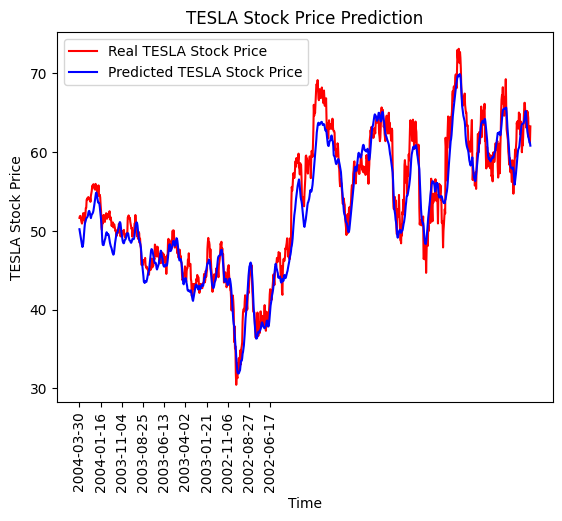

In [96]:
plt.plot(df.loc[df.shape[0]-len(py):, 'timestamp'],py, color = 'red', label = 'Real IBM Stock Price')
plt.plot(df.loc[df.shape[0]-len(pz):, 'timestamp'],pz, color = 'blue', label = 'Predicted IBM Stock Price')
plt.xticks(np.arange(0,459,50),rotation=90)
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()